In [1]:
!pip install -e ..
!pip install albumentations

Obtaining file:///home/sagemaker-user/mermaid-segmentation
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mermaidseg (pyproject.toml) ... done
  Created wheel for mermaidseg: filename=mermaidseg-0.1.0-0.editable-py3-none-any.whl size=15250 sha256=dc86f2159f114324918731620c48ac3f45ae29d915a9abd8755886181c75e3f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-23mg6rt4/wheels/c3/10/25/8ed498cb59202dbeec283c2e85c7dc9364694a847cbcc29051
Successfully built mermaidseg


  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached stringzilla-4.0.14-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (103 kB)
  Using cached simsimd-6.5.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (70 kB)
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
Using cached opencv_python_headless-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (54.0 MB)
Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.5 MB)
Using cached simsimd-6.5.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86

In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# 1. Setup

In [2]:
import albumentations as A
import numpy as np
import torch 
from torch.utils.data import DataLoader
import torch.nn.functional as F

from matplotlib import pyplot as plt 

from mermaidseg.datasets.dataset import Mermaid15Dataset
from mermaidseg.model.meta import MetaModel
from mermaidseg.io import ConfigDict
from mermaidseg.model.eval import EvaluatorSemanticSegmentation

2025-09-23 12:56:12.819971: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 12:56:12.834506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758632172.854120    9931 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758632172.860114    9931 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-23 12:56:12.879143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

CUDA Device 0: Tesla T4


device(type='cuda')

In [4]:
# seed = 42
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = True

In [5]:
!nvidia-smi

Tue Sep 23 12:56:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   32C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Data

In [6]:
transform = A.Compose([
            # A.RandomCrop(width = 512, height = 512, p=1),
            A.Resize(height=512, width=512, p=1),
        ])

In [7]:
dataset = Mermaid15Dataset(transform = transform, padding = 3)

In [8]:
len(dataset)

2189

In [9]:
dataset.df_images.head()

image_id                             region_id  \
0  00059a47-03b8-47f3-adf6-3ab5616922cf  1d31d9ea-e78d-438b-8667-0d63d1aba257   
1  0032dba6-8357-42e2-bace-988f99032286  983267a0-7349-4d3e-a23e-fb9353ca8ba5   
2  004ed958-bdd4-453d-83ed-bf773c78bfc8  1d31d9ea-e78d-438b-8667-0d63d1aba257   
3  0055fc63-bcce-485b-bb3b-5384c08ad87f  983267a0-7349-4d3e-a23e-fb9353ca8ba5   
4  0072906a-2d45-41ee-84ab-855d5f740028  1d31d9ea-e78d-438b-8667-0d63d1aba257   

            region_name  
0  Western Indo-Pacific  
1  Central Indo-Pacific  
2  Western Indo-Pacific  
3  Central Indo-Pacific  
4  Western Indo-Pacific

In [10]:
dataset.df_annotations.head()

id                              image_id  \
0  adf9f72c-f498-454b-b4c2-d3cb6a2d1c5f  00059a47-03b8-47f3-adf6-3ab5616922cf   
1  0e97b960-cc38-49ed-91c6-f760f1eff354  00059a47-03b8-47f3-adf6-3ab5616922cf   
2  1823ca56-edac-459e-b009-46c390f64afe  00059a47-03b8-47f3-adf6-3ab5616922cf   
3  dc9d3b2d-b9f9-4a46-a208-790b5c3b2ec3  00059a47-03b8-47f3-adf6-3ab5616922cf   
4  9bde5850-bb38-4ca3-88b3-43799f53f0ea  00059a47-03b8-47f3-adf6-3ab5616922cf   

                               point_id  row   col  \
0  44044125-e1b8-4580-8531-acaf18a66935  457   467   
1  e8c950a2-c37f-4f5e-8797-3f2d244257b6  457   934   
2  766bd109-c9f7-4489-8215-f2a46ffd9419  457  1401   
3  6aaaea05-f005-4e3e-a9bf-d6702e0b7736  457  1868   
4  bed04244-e299-4eec-b9b7-05e15dbf5a75  457  2335   

                   benthic_attribute_id benthic_attribute_name growth_form_id  \
0  30a987e9-b420-4db6-a83a-a1f7cabd14fb             Soft coral           None   
1  b76bca12-884b-4404-bb9f-97d505b0fe58                   Sand           None   
2  d9086647-3a82-4634-97bc-6e10347af39b         Bare substrate           None   
3  ed2332ed-0762-45fb-87a3-d315e218faf1                 Rubble           None   
4  ed2332ed-0762-45fb-87a3-d315e218faf1                 Rubble           None   

  growth_form_name                       updated_on  \
0             None 2025-08-26 14:55:15.009823+00:00   
1             None 2025-08-26 14:55:15.039272+00:00   
2             None 2025-08-26 14:55:15.085659+00:00   
3             None 2025-08-26 14:55:15.133907+00:00   
4             None 2025-08-26 14:55:15.181096+00:00   

                              region_id           region_name  
0  1d31d9ea-e78d-438b-8667-0d63d1aba257  Western Indo-Pacific  
1  1d31d9ea-e78d-438b-8667-0d63d1aba257  Western Indo-Pacific  
2  1d31d9ea-e78d-438b-8667-0d63d1aba257  Western Indo-Pacific  
3  1d31d9ea-e78d-438b-8667-0d63d1aba257  Western Indo-Pacific  
4  1d31d9ea-e78d-438b-8667-0d63d1aba257  Western Indo-Pacific

(3, 512, 512) (512, 512)


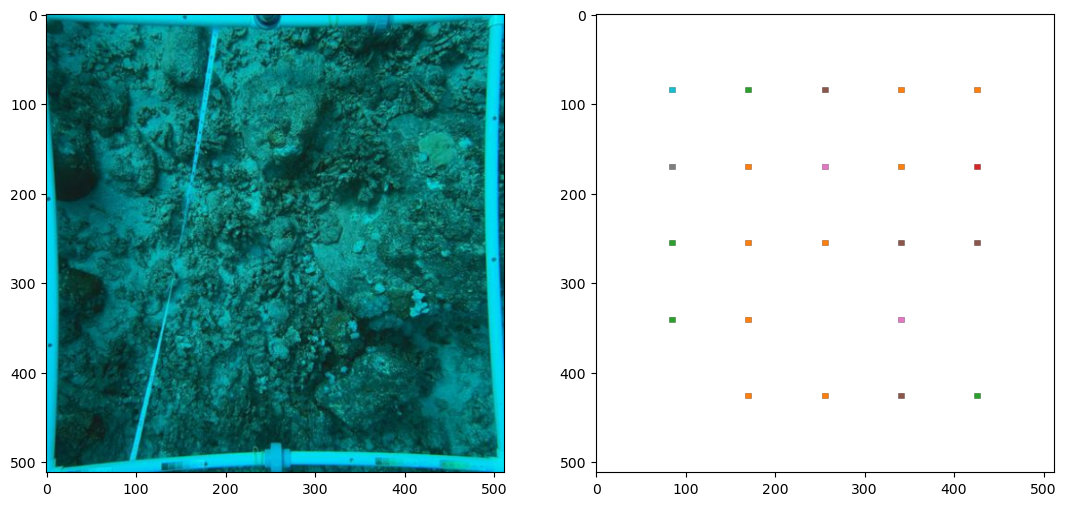

In [11]:
image, mask, annotations = dataset[0]
print(image.shape, mask.shape)

fig, ax = plt.subplots(figsize= (13,6), ncols = 2)
ax[0].imshow(image.transpose(1,2,0))
ax[1].imshow(np.where(mask>0, mask, np.nan), cmap = "tab10", vmin=1, vmax=10)
plt.show()

In [12]:
# data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2, drop_last=True, collate_fn = dataset.collate_fn)
# len(data_loader)

1094

In [13]:
from torch.utils.data import random_split

# Calculate lengths for train and test splits (80-20 split)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Create train and val datasets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_dataset = torch.utils.data.Subset(train_dataset, range(1000))
# val_dataset = torch.utils.data.Subset(val_dataset, range(300))

batch_size = 4
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True, collate_fn = dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True, collate_fn = dataset.collate_fn)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 437
Number of validation batches: 109


In [15]:
for inputs, labels in train_loader:
    print(f"Batch shape: {inputs.shape}")
    print(f"Mask shape: {labels.shape}") 
    break

Batch shape: torch.Size([4, 3, 512, 512])
Mask shape: torch.Size([4, 512, 512])


# 3. Model Pipeline

## 3.1 Model & Training Setup

In [31]:
model_kwargs = ConfigDict({"name": "Segformer",
                "num_classes": dataset.num_classes,
                "encoder_name": "EPFL-ECEO/segformer-b2-finetuned-coralscapes-1024-1024", #"nvidia/mit-b2"
                })   

training_kwargs = ConfigDict(
    {
        "epochs": 10,
        "optimizer": {
            "type": "AdamW",     
            "lr": 0.00006,                                                
            "weight_decay": 0.01,         
        },
        "scheduler": {
            "type": "PolynomialLR",
            "power": 1,
            "total_iters": 10
        }
    }
)

In [32]:
meta_model = MetaModel(run_name = "mermaid-segmentation-test-run-coralscapes-1", 
                       num_classes = dataset.num_classes,
                       device = device,
                       model_kwargs = model_kwargs,
                       training_kwargs = training_kwargs,)

evaluator = EvaluatorSemanticSegmentation(num_classes=dataset.num_classes,
                                            device=device,
                                            )

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at EPFL-ECEO/segformer-b2-finetuned-coralscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([40]) in the checkpoint and torch.Size([16]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([40, 768, 1, 1]) in the checkpoint and torch.Size([16, 768, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.2 Model Training

In [33]:
# if(start_epoch is None):
start_epoch = 0
end_epoch = meta_model.training_kwargs["epochs"]

train_loss_list = []
train_accuracy_list = []
train_iou_list = []

val_loss_list = []
val_accuracy_list = []
val_iou_list = []

for epoch in range(start_epoch, end_epoch):
    print("Epoch {}/{}".format(epoch+1, end_epoch))
    meta_model.model.train(True)
    train_loss = meta_model.train_epoch(train_loader)
    train_loss_list.append(train_loss)
    print('LOSS train {}'.format(train_loss))

    meta_model.model.eval()
    train_results = evaluator.evaluate_model(dataloader = train_loader, meta_model=meta_model)
    train_accuracy_list.append(train_results["accuracy"])
    train_iou_list.append(train_results["mean_iou"])

    val_loss = meta_model.validation_epoch(val_loader)
    val_loss_list.append(val_loss)
    print('LOSS valid {}'.format(val_loss))

    val_results = evaluator.evaluate_model(dataloader = val_loader, meta_model=meta_model)
    val_accuracy_list.append(val_results["accuracy"])
    val_iou_list.append(val_results["mean_iou"])
    print('Validation results:')
    print(val_results)
    print("_______________")
    print()

Epoch 1/10


  2%|▏         | 10/437 [00:07<04:52,  1.46it/s]

100%|██████████| 437/437 [05:06<00:00,  1.43it/s]

LOSS train 1.886662819701965



100%|██████████| 109/109 [00:21<00:00,  4.97it/s]

LOSS valid 1.5928803261266935


Validation results:
{'accuracy': 0.4853927791118622, 'mean_iou': 0.2183467000722885}
_______________

Epoch 2/10


100%|██████████| 437/437 [05:08<00:00,  1.42it/s]

LOSS train 1.5364093738235107



100%|██████████| 109/109 [00:22<00:00,  4.95it/s]

LOSS valid 1.4818597490634393


Validation results:
{'accuracy': 0.5160354971885681, 'mean_iou': 0.2545824646949768}
_______________

Epoch 3/10


100%|██████████| 437/437 [05:09<00:00,  1.41it/s]

LOSS train 1.3509246757428761



100%|██████████| 109/109 [00:21<00:00,  4.97it/s]

LOSS valid 1.5257239757327858


Validation results:
{'accuracy': 0.5082904100418091, 'mean_iou': 0.27643775939941406}
_______________

Epoch 4/10


100%|██████████| 437/437 [05:08<00:00,  1.41it/s]

LOSS train 1.1769471141239052



100%|██████████| 109/109 [00:21<00:00,  4.96it/s]

LOSS valid 1.4827693799220094


Validation results:
{'accuracy': 0.5287222862243652, 'mean_iou': 0.283866822719574}
_______________

Epoch 5/10


  3%|▎         | 14/437 [00:10<05:20,  1.32it/s]


KeyboardInterrupt: 

In [35]:
import time 
import os 
import json

def save_model_checkpoint(meta_model, epoch, loss, vloss, val_mean_iou, val_mean_accuracy, save_path, final_checkpoint = False):
    timestamp = time.strftime('%Y%m%d%H')

    checkpoint = {
        # Model and training state
        "model_state_dict": meta_model.model.state_dict(),
        # "optimizer_state_dict": meta_model.optimizer.state_dict(),
        "epoch": epoch,
        # Performance metrics
        "loss": loss,
        "val_metrics": {
            "validation_loss": vloss,
            "validation_mean_iou": val_mean_iou,
            "validation_mean_accuracy": val_mean_accuracy,
        },
        
        # Additional metadata (optional)
        "timestamp": timestamp
    }    
    
    model_path = f'{save_path}/model_checkpoints/{meta_model.run_name}/model_{timestamp}'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    torch.save(checkpoint, model_path)

save_model_checkpoint(meta_model = meta_model, 
                        epoch = end_epoch, 
                        loss = train_loss_list[-1], 
                        vloss = val_loss_list[-1], 
                        val_mean_iou = val_iou_list[-1], 
                        val_mean_accuracy = val_accuracy_list[-1], 
                        save_path = "..", 
                        final_checkpoint = False)

metrics_json = {
    "train_loss": train_loss_list,
    "train_accuracy": train_accuracy_list,
    "train_iou": train_iou_list,
    "val_loss": val_loss_list,
    "val_accuracy": val_accuracy_list,
    "val_iou": val_iou_list,
}

timestamp = time.strftime('%Y%m%d%H')
metrics_path = f'../model_runs/{meta_model.run_name}/model_{timestamp}'
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
with open(metrics_path, 'w') as f:
    json.dump(metrics_json, f)

## 3.3 Performance Analysis

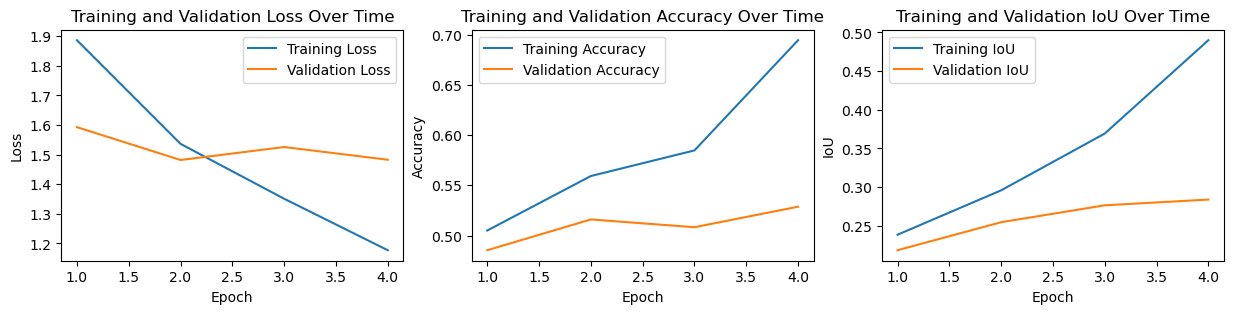

In [36]:
fig, ax = plt.subplots(figsize=(15, 3), ncols = 3)
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accuracy_list) + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_list) + 1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Time')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, len(train_iou_list) + 1), train_iou_list, label='Training IoU')
plt.plot(range(1, len(val_iou_list) + 1), val_iou_list, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU Over Time')
plt.legend()
plt.show()

In [37]:
from torchmetrics.classification import Accuracy, JaccardIndex


metric_dict = {
            "accuracy": Accuracy(task="multiclass", num_classes=int(dataset.num_classes), ignore_index = 0).to(device),
            "mean_iou": JaccardIndex(task="multiclass", num_classes=int(dataset.num_classes), ignore_index = 0).to(device),
            "iou": JaccardIndex(task="multiclass", num_classes=int(dataset.num_classes), ignore_index = 0, average='none').to(device)
            }

evaluator_final = EvaluatorSemanticSegmentation(num_classes=dataset.num_classes,
                                            device=device,
                                            metric_dict = metric_dict
                                            )

final_val_results = evaluator_final.evaluate_model(dataloader = val_loader, meta_model=meta_model)

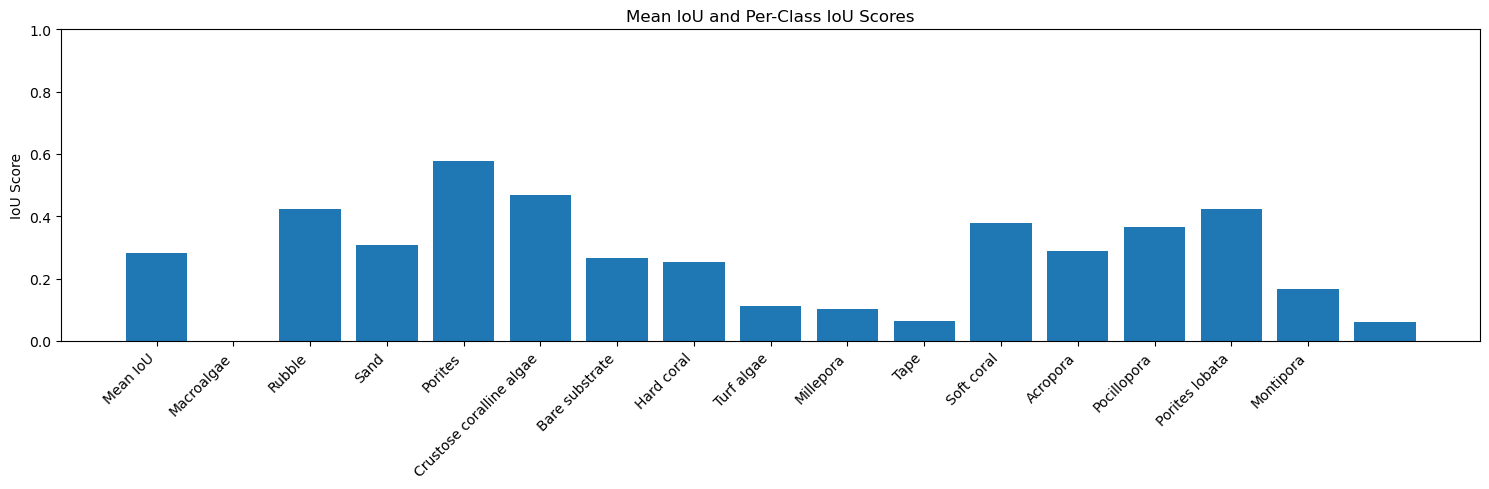

In [38]:
iou_values = [final_val_results["mean_iou"]] + final_val_results["iou"].tolist()
labels = ["Mean IoU"] + list(dataset.label2id.keys())

plt.figure(figsize=(15,5))
plt.bar(range(len(iou_values)), iou_values)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel("IoU Score")
plt.ylim(0, 1)
plt.title("Mean IoU and Per-Class IoU Scores")
plt.tight_layout()
plt.show()

## 3.4 Qualitative Analysis

### Train Image

In [39]:
image, label, pred_proba = evaluator_final.evaluate_image(dataloader = train_loader, meta_model = meta_model, proba = True)
pred_proba = F.softmax(torch.from_numpy(pred_proba), dim=0).numpy()
pred_argmax = pred_proba.argmax(axis=0)
threshold = 0.3
pred_thresh = pred_proba.argmax(axis=0)
pred_thresh[pred_proba.max(axis=0)<threshold] = 0

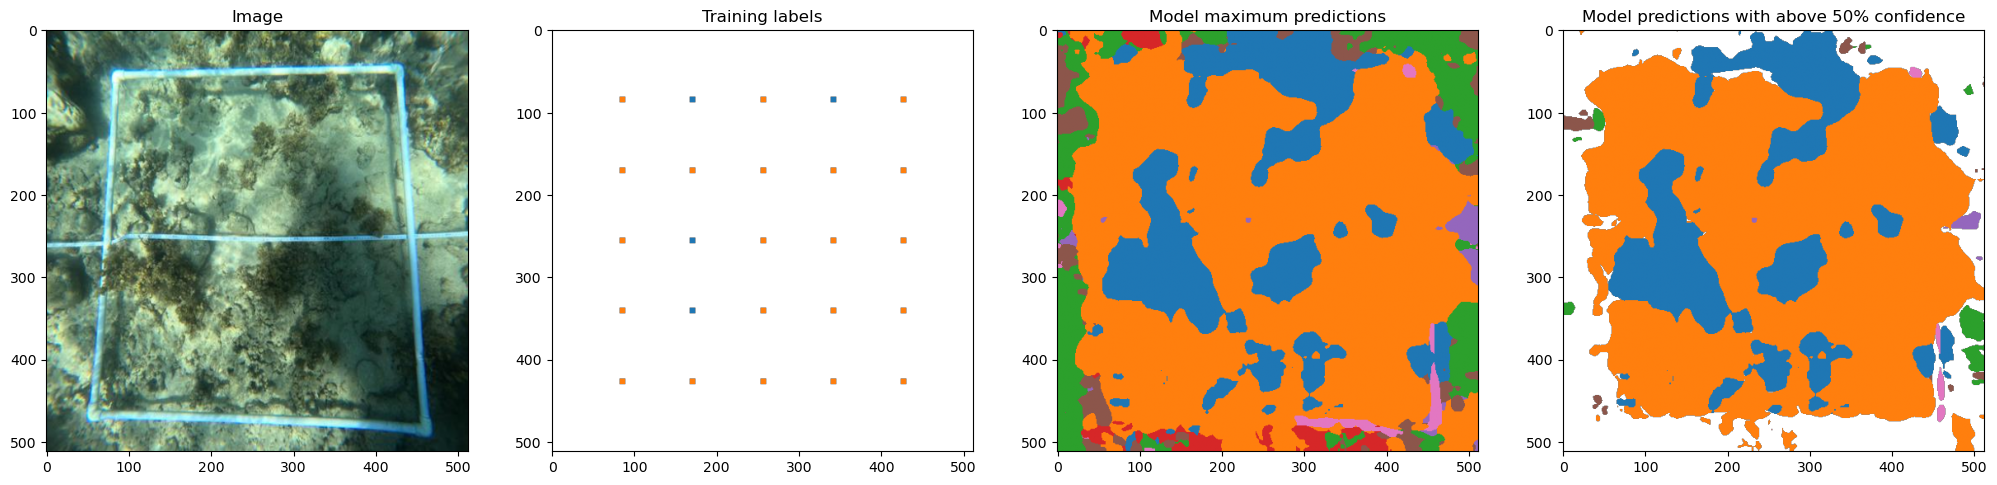

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
ax[0].imshow(image.transpose(1, 2, 0))
ax[0].set_title("Image")
ax[1].imshow(np.where(label>0, label, np.nan), cmap='tab10', vmin = 0, vmax = 16)
ax[1].set_title("Training labels")
ax[2].imshow(pred_argmax, cmap='tab10', vmin = 0, vmax = 16)
ax[2].set_title("Model maximum predictions")
ax[3].imshow(np.where(pred_thresh>0, pred_thresh, np.nan), cmap='tab10', vmin = 0, vmax = 16)
ax[3].set_title("Model predictions with above 50% confidence")
plt.show()

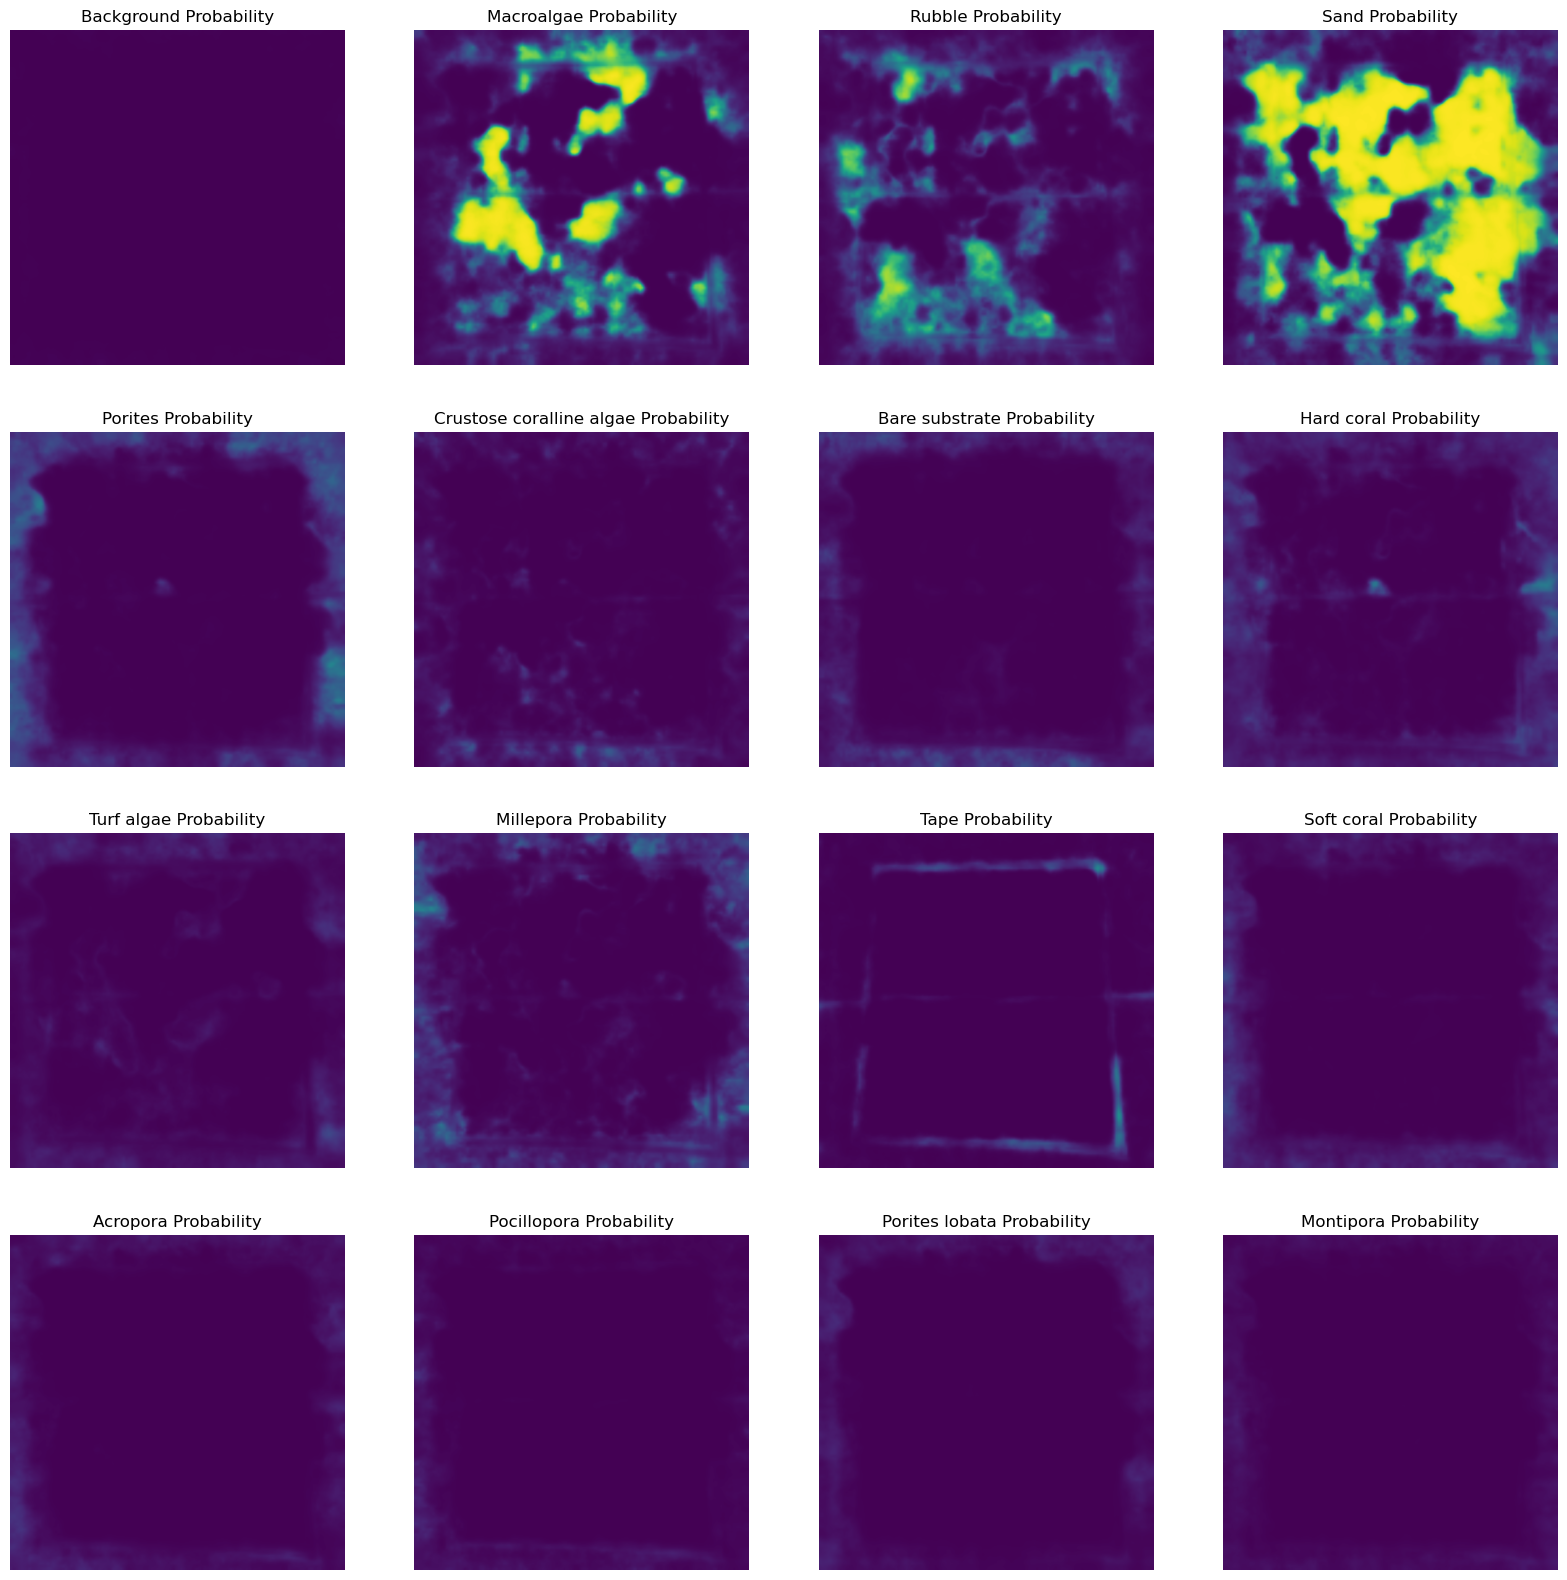

In [41]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.flatten()
for i, ax in enumerate(ax):
    ax.imshow(pred_proba[i], cmap='viridis', vmin = 0, vmax = 1)
    if i == 0:
        ax.set_title(f"Background Probability")
    else:
        ax.set_title(f"{dataset.id2label[i]} Probability")
    ax.axis('off')
plt.show()

### Test Image

In [42]:
image, label, pred_proba = evaluator_final.evaluate_image(dataloader = val_loader, meta_model = meta_model, proba = True)
pred_proba = F.softmax(torch.from_numpy(pred_proba), dim=0).numpy()
pred_argmax = pred_proba.argmax(axis=0)
threshold = 0.3
pred_thresh = pred_proba.argmax(axis=0)
pred_thresh[pred_proba.max(axis=0)<threshold] = 0

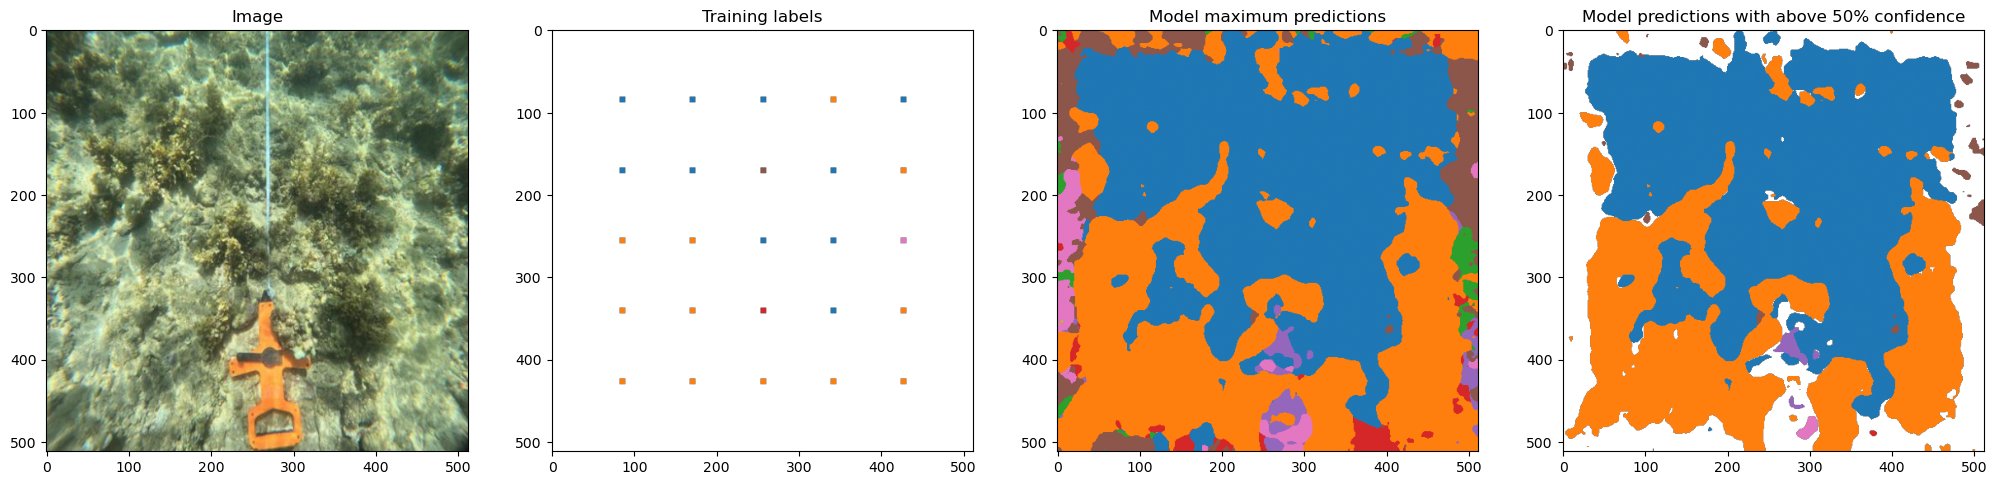

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
ax[0].imshow(image.transpose(1, 2, 0))
ax[0].set_title("Image")
ax[1].imshow(np.where(label>0, label, np.nan), cmap='tab10', vmin = 0, vmax = 16)
ax[1].set_title("Training labels")
ax[2].imshow(pred_argmax, cmap='tab10', vmin = 0, vmax = 16)
ax[2].set_title("Model maximum predictions")
ax[3].imshow(np.where(pred_thresh>0, pred_thresh, np.nan), cmap='tab10', vmin = 0, vmax = 16)
ax[3].set_title("Model predictions with above 50% confidence")
plt.show()

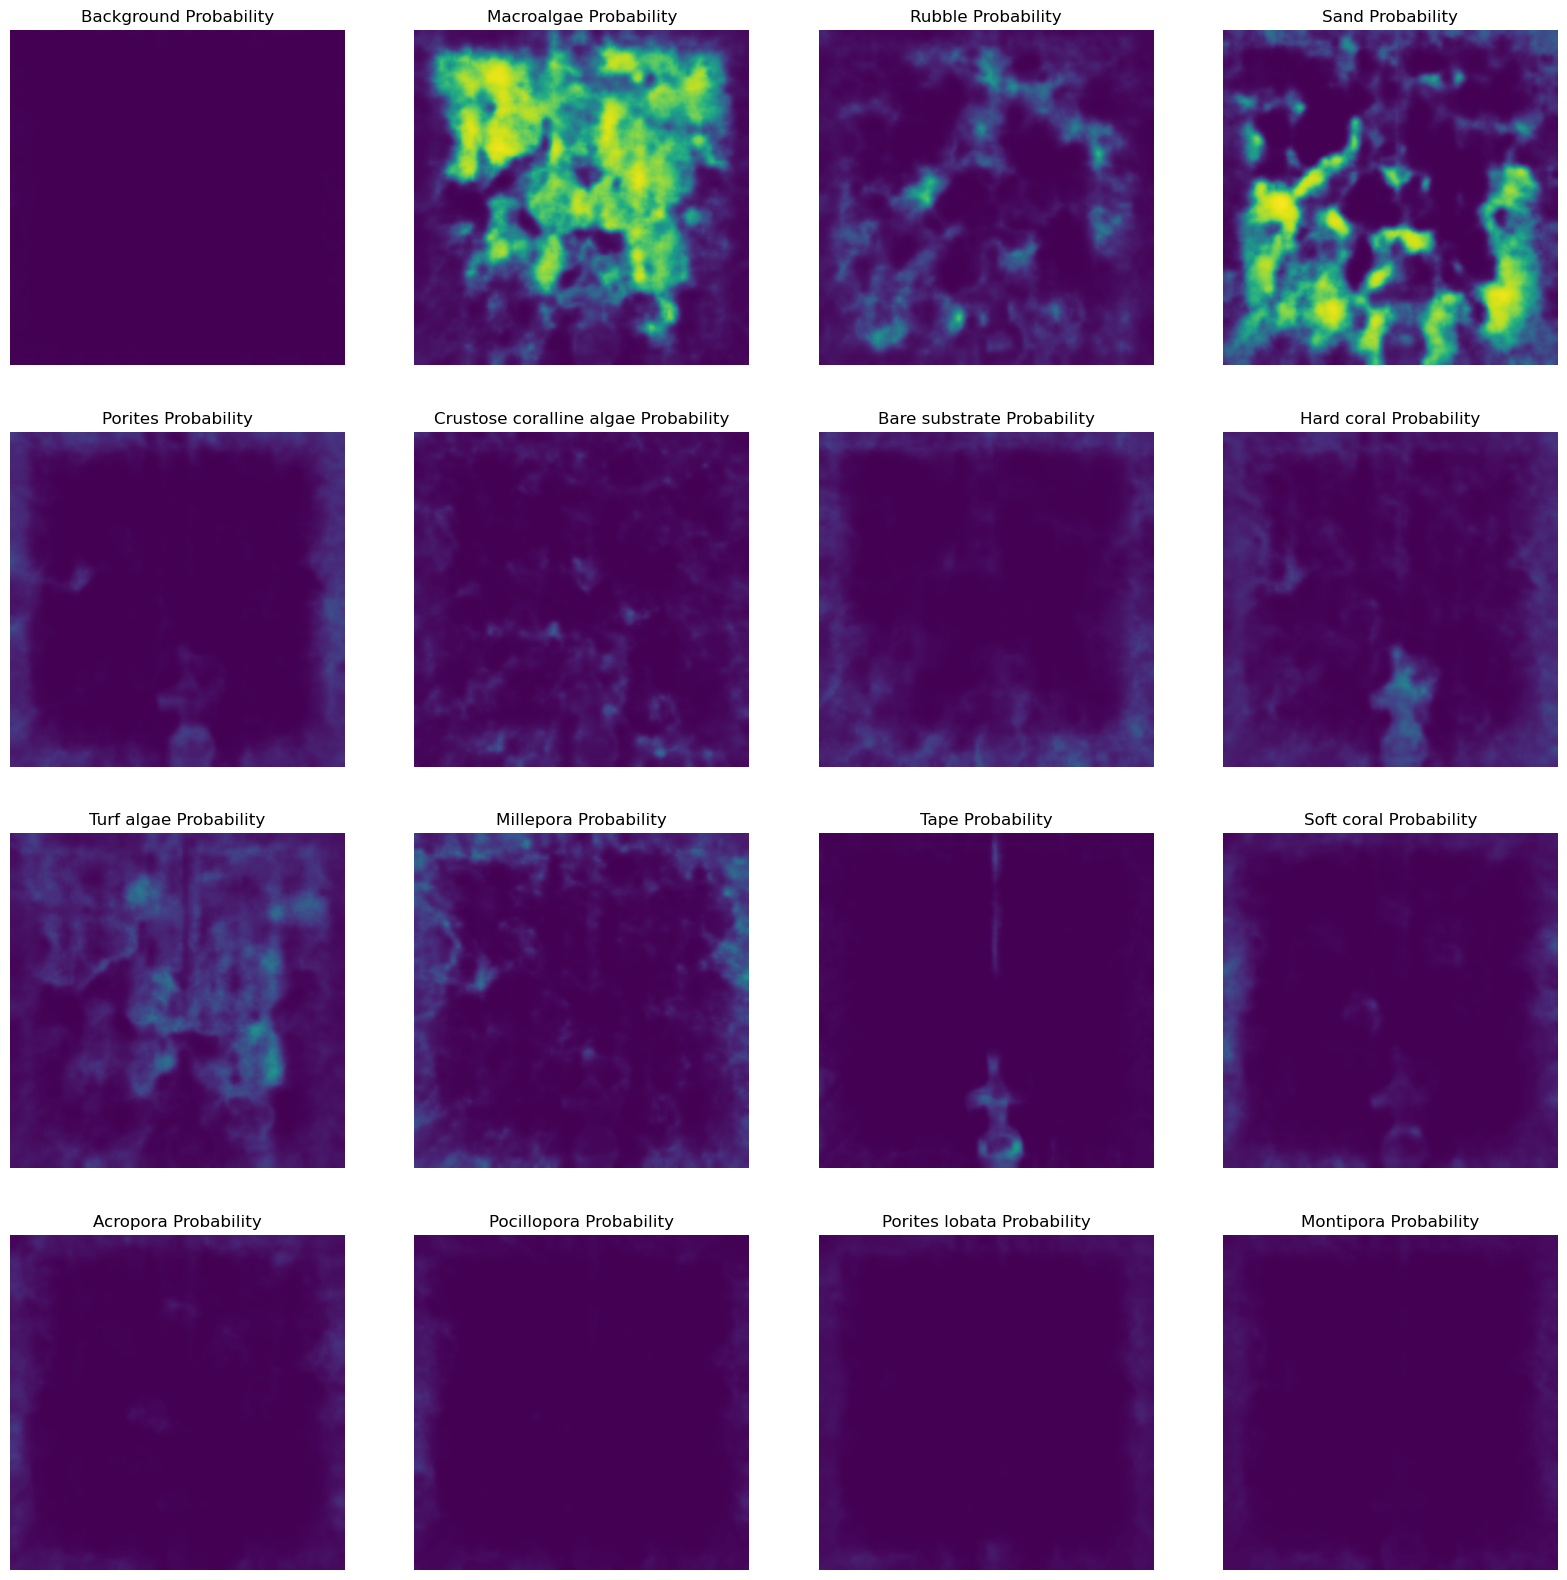

In [44]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.flatten()
for i, ax in enumerate(ax):
    ax.imshow(pred_proba[i], cmap='viridis', vmin = 0, vmax = 1)
    if i == 0:
        ax.set_title(f"Background Probability")
    else:
        ax.set_title(f"{dataset.id2label[i]} Probability")
    ax.axis('off')
plt.show()

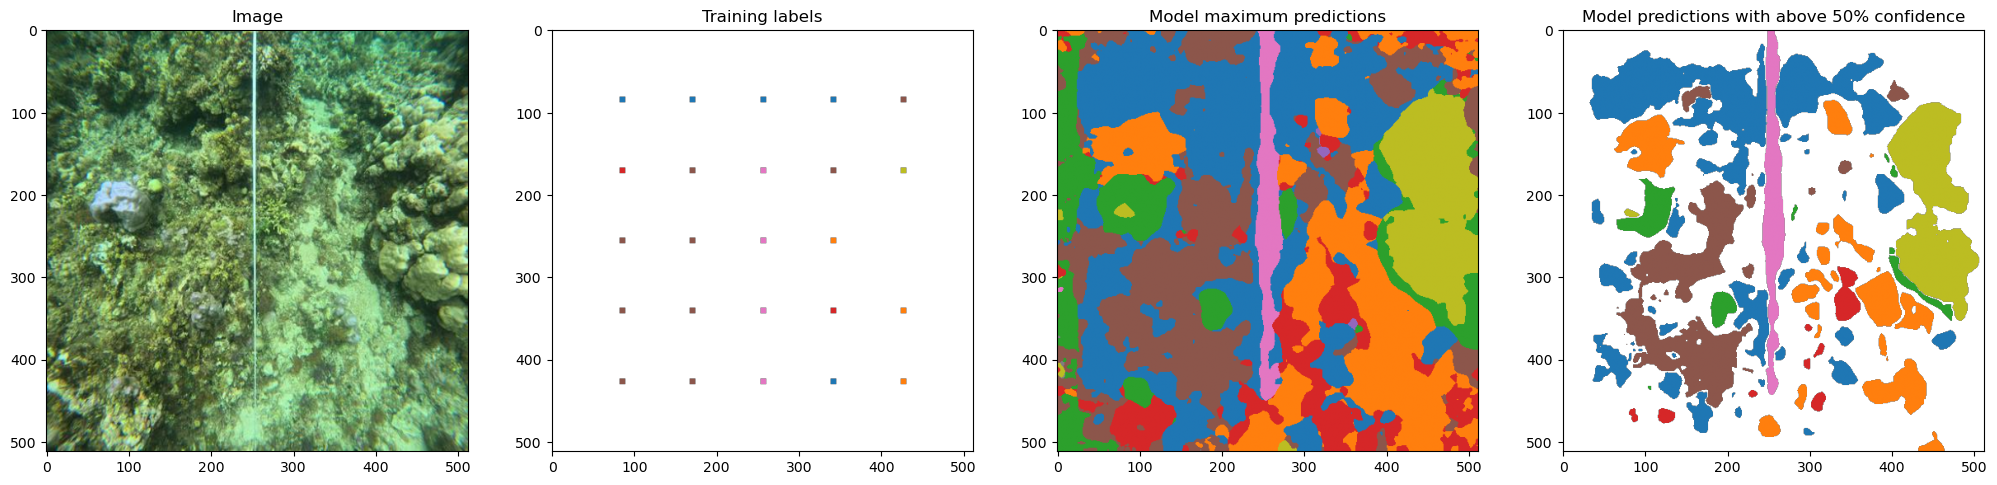

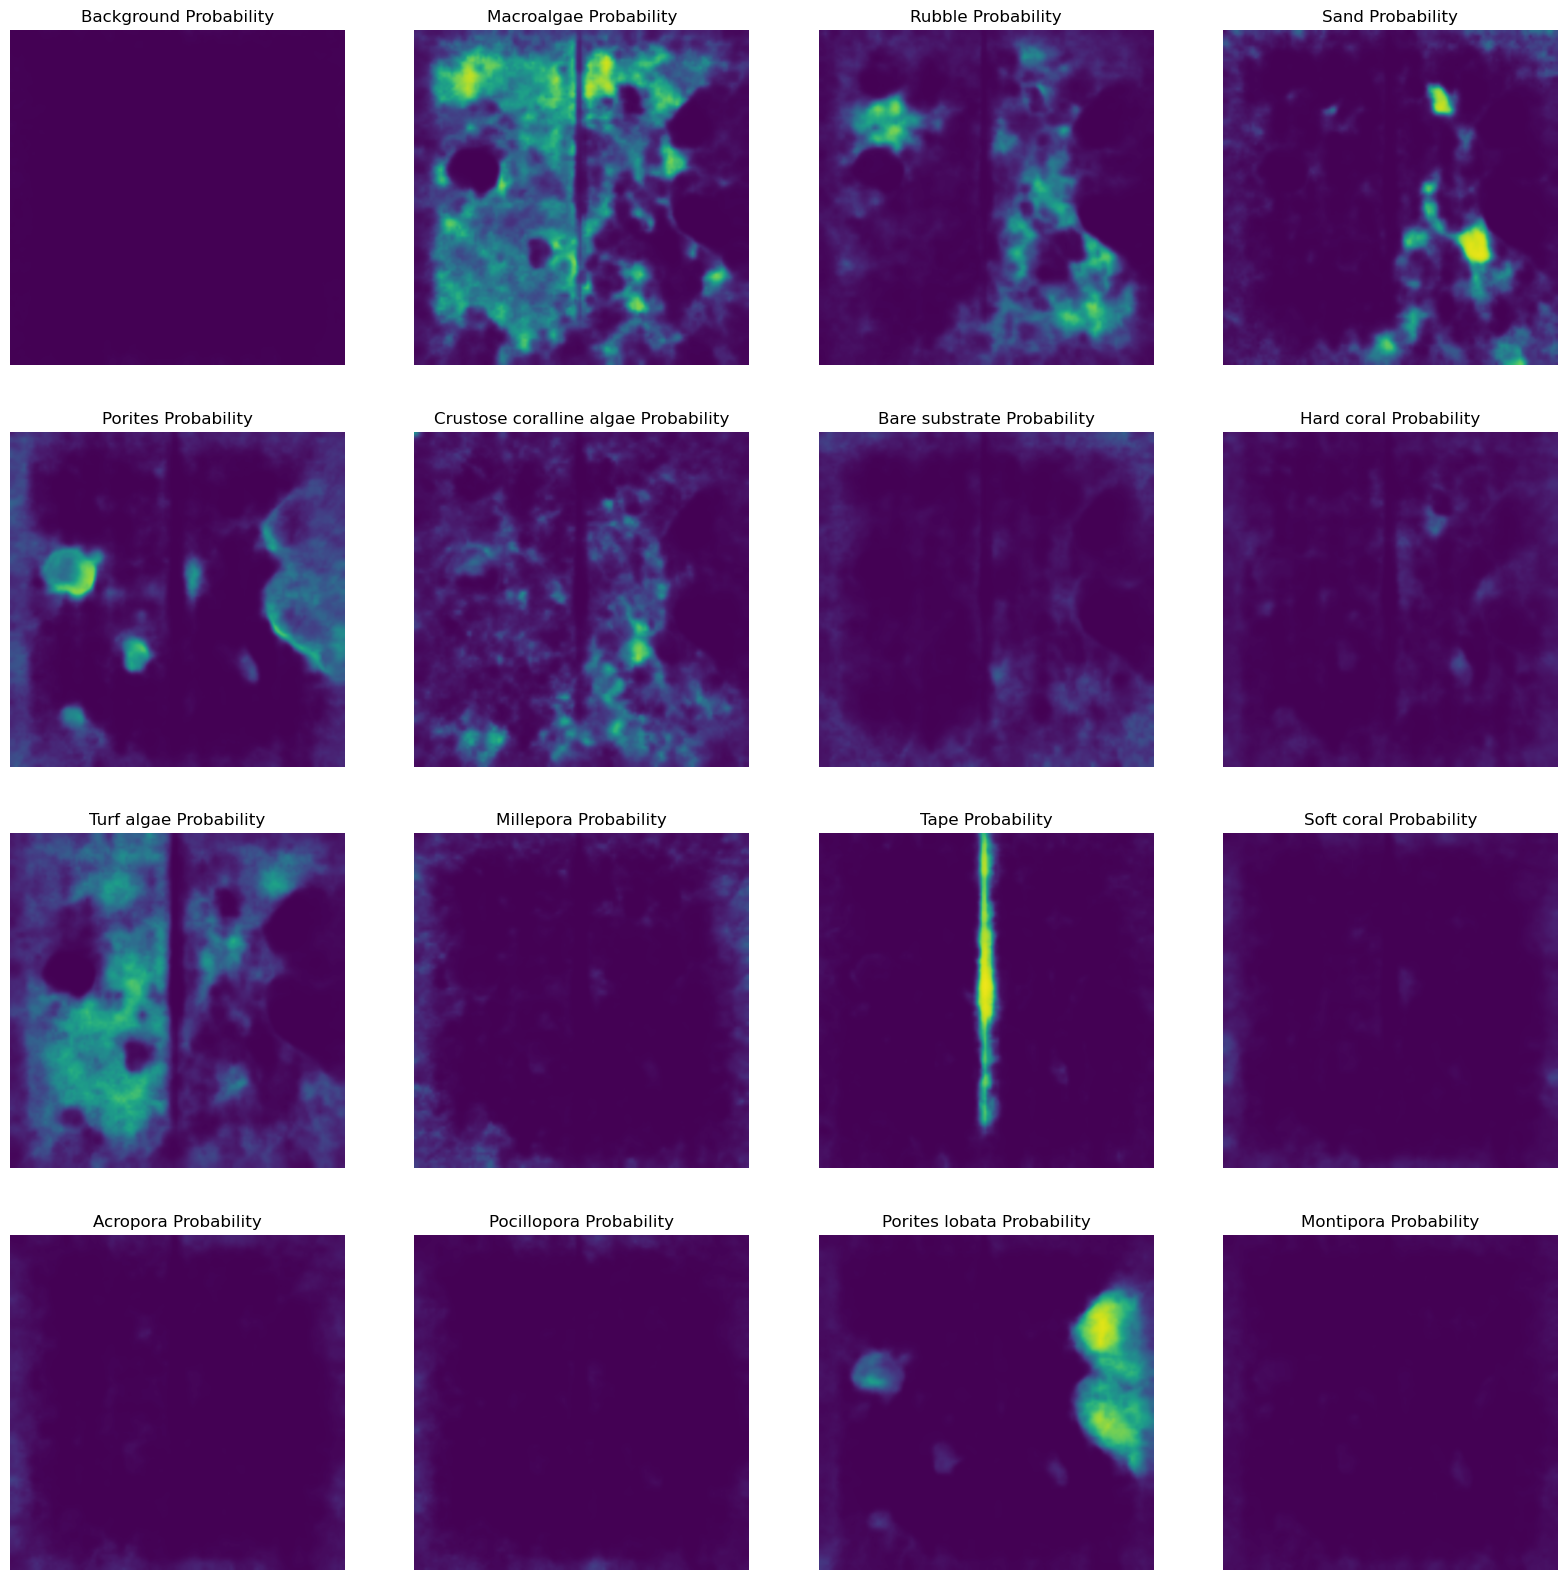

In [45]:
image, label, pred_proba = evaluator_final.evaluate_image(dataloader = train_loader, meta_model = meta_model, proba = True)
pred_proba = F.softmax(torch.from_numpy(pred_proba), dim=0).numpy()
pred_argmax = pred_proba.argmax(axis=0)
threshold = 0.5
pred_thresh = pred_proba.argmax(axis=0)
pred_thresh[pred_proba.max(axis=0)<threshold] = 0

fig, ax = plt.subplots(1, 4, figsize=(25, 7))
ax[0].imshow(image.transpose(1, 2, 0))
ax[0].set_title("Image")
ax[1].imshow(np.where(label>0, label, np.nan), cmap='tab10', vmin = 0, vmax = 16)
ax[1].set_title("Training labels")
ax[2].imshow(pred_argmax, cmap='tab10', vmin = 0, vmax = 16)
ax[2].set_title("Model maximum predictions")
ax[3].imshow(np.where(pred_thresh>0, pred_thresh, np.nan), cmap='tab10', vmin = 0, vmax = 16)
ax[3].set_title("Model predictions with above 50% confidence")
plt.show()

fig, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.flatten()
for i, ax in enumerate(ax):
    ax.imshow(pred_proba[i], cmap='viridis', vmin = 0, vmax = 1)
    if i == 0:
        ax.set_title(f"Background Probability")
    else:
        ax.set_title(f"{dataset.id2label[i]} Probability")
    ax.axis('off')
plt.show()

## TODO
- Create an evaluator for analysis purposes - with per class IoU, confusion matrix
- Get predictions above a specific threshold (or visualize probabilities)
- 